<a href="https://colab.research.google.com/github/grapefruit224/Projects/blob/master/Movie_RecommendationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#영화추천시스템

In [ ]:
import torch
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


##데이터 준비하기

In [ ]:
train = pd.read_csv("/content/gdrive/My Drive/ml-100k/ua.base",
                    sep = "\t", names = ["user","movie", "rating", "timestamp"])
test = pd.read_csv("/content/gdrive/My Drive/ml-100k/ua.test",
                    sep = "\t", names = ["user","movie", "rating", "timestamp"])
movie = pd.read_csv("/content/gdrive/My Drive/ml-100k/u.item",
                    sep = "|", names = ["movie_id", "movie", "-", "url", "num1", "num2", "num3", "num4", "num5", "num6", "num7", "num8", "num9", "num10", "num11" ,"num12", "num13", "num14", "num15", "num16", "num17", "num18", "num19", "num20"],
                    encoding='latin-1')
movie = movie[["movie_id", "movie"]]

In [ ]:
items = torch.LongTensor(train['movie'])
users = torch.LongTensor(train['user'])
ratings = torch.FloatTensor(train['rating'])

items_test = torch.LongTensor(test['movie'])
users_test = torch.LongTensor(test['user'])
ratings_test = torch.FloatTensor(test['rating'])

##Latent Factor 모델을 이용하여 학습하기

In [ ]:
lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.001
lambda4 = 0.001

rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad = True)
Q = torch.randn(numUsers, rank, requires_grad = True)

bias_user = torch.randn(numUsers, requires_grad = True)
bias_item = torch.randn(numItems, requires_grad = True)
mean = ratings.sum() / len(ratings)

X = []
Y = []
Y_test = []

optimizer = torch.optim.Adam([P, Q, bias_item, bias_user], lr = 0.1)

for epoch in range(1001):
    hypothesis = torch.sum(P[items] * Q[users], dim = 1) + mean + bias_item[items] + bias_user[users]
    mse = torch.sqrt(F.mse_loss(hypothesis, ratings))
    loss = mse + lambda1 * (P ** 2).sum() + lambda2 * (Q ** 2).sum() + lambda3 * (bias_item ** 2).sum() + lambda4 * (bias_user ** 2).sum()


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim = 1) + mean + bias_item[items_test] + bias_user[users_test]
        mse_test = torch.sqrt(F.mse_loss(hypo_test, ratings_test))

        X.append(epoch)
        Y.append(mse)
        Y_test.append(mse_test)


    if epoch % 100 == 0:
        print("epoch: {}, cost: {:.6f}".format(epoch, mse.item()))

epoch: 0, cost: 3.611604
epoch: 100, cost: 0.843025
epoch: 200, cost: 0.838242
epoch: 300, cost: 0.837645
epoch: 400, cost: 0.837414
epoch: 500, cost: 0.837265
epoch: 600, cost: 0.837202
epoch: 700, cost: 0.837160
epoch: 800, cost: 0.837133
epoch: 900, cost: 0.837144
epoch: 1000, cost: 0.837128


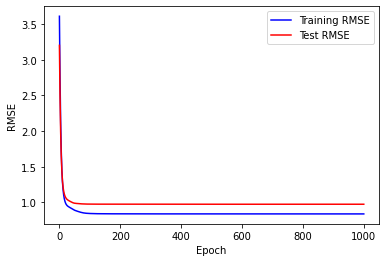

In [ ]:
plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.plot(X, Y, c = "blue", label = "Training RMSE")
plt.plot(X, Y_test, c = "red", label = "Test RMSE")
plt.legend()
plt.show()

##13번 User에게 추천하기 (knn search)



###13번 user의 예상 별점이 가장 높은 영화 top 20개를 찾아서 id 및 영화이름 출력하기

In [ ]:
predict = torch.zeros(len(P))
for i in range(len(P)):
    predict[i] = torch.dot(P[i], Q[13]) + mean + bias_item[i] + bias_user[13] # regularzation, bias를 추가해줌

In [ ]:
predict_sort = torch.sort(predict, descending = True)
predict_ratings_sort = predict_sort[1][:20] # 정렬하여 상위 20개 슬라이싱

In [ ]:
movie = movie.set_index(["movie_id"]) # moive_id를 index로 설정해줌
movie.loc[predict_ratings_sort, :]

movie
movie_id                                      
50                            Star Wars (1977)
181                  Return of the Jedi (1983)
172            Empire Strikes Back, The (1980)
135               2001: A Space Odyssey (1968)
127                      Godfather, The (1972)
100                               Fargo (1996)
511                  Lawrence of Arabia (1962)
174             Raiders of the Lost Ark (1981)
276                   Leaving Las Vegas (1995)
187             Godfather: Part II, The (1974)
285                      Secrets & Lies (1996)
479                             Vertigo (1958)
134                        Citizen Kane (1941)
423          E.T. the Extra-Terrestrial (1982)
204                  Back to the Future (1985)
663                         Being There (1979)
199       Bridge on the River Kwai, The (1957)
510              Magnificent Seven, The (1954)
430                           Duck Soup (1933)
302                   L.A. Confidential (1997)

###Task 3-2. (5 점) Latent Matrix P와 Q를 이용하여 13번 user와 cosine similarity가 가장 유사한 영화 top 20개를 찾아서 id 및 영화이름 출력하기

In [ ]:
def cosine_similarity(p, q_13):
    deno = (torch.dot(p, p) ** 0.5) * (torch.dot(q_13, q_13) ** 0.5)

    if (deno == 0):
        deno = 0.00000001
        
    c_s = torch.dot(p, q_13) / deno
    return c_s

predict_cs = torch.zeros(len(P))
for i in range(len(P)):
    predict_cs[i] = cosine_similarity(P[i], Q[13])

In [ ]:
predict_cs_sort = torch.sort(predict_cs, descending = True)
predict_cs_sort_index = predict_cs_sort[1][:20]

In [ ]:
movie.loc[predict_cs_sort_index, :]

movie
movie_id                                                 
814                         Great Day in Harlem, A (1994)
868                               Hearts and Minds (1996)
909                               Dangerous Beauty (1998)
848                               Murder, My Sweet (1944)
867                          Whole Wide World, The (1996)
811       Thirty-Two Short Films About Glenn Gould (1993)
917                                 Mercury Rising (1998)
900                                         Kundun (1997)
915                                 Primary Colors (1998)
1541                    Beans of Egypt, Maine, The (1994)
390                            Fear of a Black Hat (1993)
851           Two or Three Things I Know About Her (1966)
793                                       Crooklyn (1994)
733                                        Go Fish (1994)
865                                 Ice Storm, The (1997)
492                                   East of Eden (1955)
896                           Sweet Hereafter, The (1997)
592                                     True Crime (1995)
279       Once Upon a Time... When We Were Colored (1995)
522                                    Down by Law (1986)

##영화 클러스터링하기 (k-means clustering)

###다음을 만족하는 k-means clustering 알고리즘 구현하기

- 각 영화가 속한 cluster를 정할 때, cosine similarity를 기준으로 정하기

In [ ]:
def kmeans(k, points):
    cost = 0
    prev_assignment = []
    
    centroids = points[np.random.choice(points.shape[0], replace = False, size = k)]

    for epoch in range(10):
        assignments = [assign(point, centroids, k) for point in points]

        centroids = compute_centroids(assignments, points, k)

        if prev_assignment == assignments:
            break
        prev_assignment = assignments
    
    return assignments, centroids

def assign(point, centroids, k):
    return max(range(k), key = lambda i: cosine_similarity(point, centroids[i]))

def compute_centroids(assignments, points, k):
    vec_sum = [np.zeros(len(points[0])) for _ in range(k)]
    counts = [0] * k

    for i, p in zip(assignments, points):
        vec_sum[i] += p
        counts[i] += 1
    
    return [vec_sum[i]/counts[i] if counts[i] > 0 else random.choice(points) for i in range(k)]


def cosine_similarity(p, c):
    deno = np.sqrt(np.dot(p, p)) * np.sqrt(np.dot(c, c))
    if (deno == 0):
        deno = 0.00000001
    cs = np.dot(p, c) / deno # 위에 정의된 함수에서 torch를 np로 수정
    return cs

###k=1, ..., 40 까지 바꿔가면서 cost 값을 계산하고 이를 matplotlib을 활용하여 그래프로 그리기

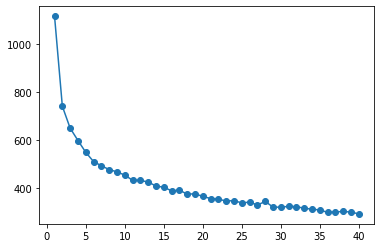

In [ ]:
points = P.detach().numpy()
cost_k = []

for k in range(1, 41):
    cost = 0
    assignments, centroids = kmeans(k, points)
    for a,p in zip(assignments, points):
        cost += (1 - cosine_similarity(centroids[a], p))
    cost_k.append(cost)

plt.plot(range(1, 41), cost_k, marker = 'o')
plt.show()  


###가장 적절해보이는 k 선택하기

In [ ]:
k = 3
assignments, centroids = kmeans(k, points)

##차원 축소 및 시각화 (PCA)

###P 행렬와 Q 행렬을 합쳐 Z행렬 만들기

In [ ]:
Z = torch.cat([P, Q], dim = 0)
Z = Z - Z.mean(axis = 0)
Z = Z.detach().numpy()

###Z 행렬에서 PCA 수행하여 2차원 데이터로 줄인 Zp 만들기

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # 2차원으로 PCA
pca.fit(Z)
Z_p = pca.transform(Z)

###matplotlib을 활용하여 Zp의 scatter plot 그리기

####P행렬과 Q행렬의 점들을 서로 다른 색으로 그리기

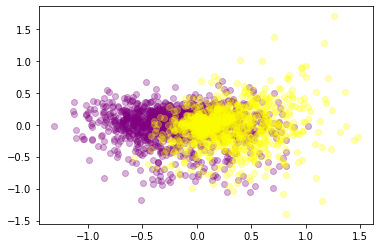

In [ ]:
Z_p1 = Z_p[:1683,:] # P
Z_p2 = Z_p[1683:,:] # Q
plt.scatter(Z_p1[:,0], Z_p1[:,1], c = 'purple', alpha = 0.3)
plt.scatter(Z_p2[:,0], Z_p2[:,1], c = 'yellow', alpha = 0.3)

plt.show()

####3번째 의 결과 점들을 다른 색으로 그려 강조하기

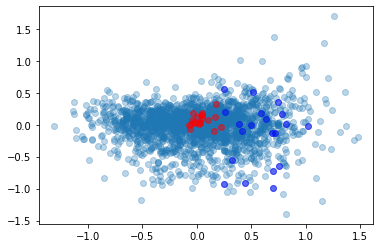

In [ ]:
plt.scatter(Z_p[:,0], Z_p[:,1], alpha = 0.3)
for i in predict_ratings_sort:
    plt.scatter(Z_p[i,0], Z_p[i,1], c = 'blue', alpha = 0.5) # 예상 평점 상위 20개의 영화
for i in predict_cs_sort_index:
    plt.scatter(Z_p[i,0], Z_p[i,1], c = 'red', alpha = 0.5) # cosine similarity 상위 20개의 영화

plt.show()

####4번째 에서 구한 cluster들을 각기 다른 색으로 그리기

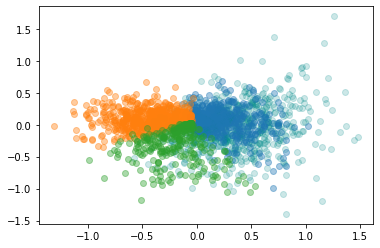

In [ ]:
plt.scatter(Z_p2[:,0], Z_p2[:,1], c = 'darkcyan', alpha = 0.2)

clusters = [[] for _ in range(k)]

for a, p in zip(assignments, Z_p1):
    clusters[a].append(p) # 해당하는 중심점에 점 모아두기

for cluster in clusters:
    plt.scatter(*zip(*cluster), alpha = 0.4)

plt.show()